In [342]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
# plt.style.use('ggplot')
# % matplotlib inline

In [343]:
df = pd.read_csv('CrisisLexT26/2013_Boston_bombings/2013_Boston_bombings-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related - but not informative    512
Related and informative          417
Not applicable                    52
Not related                       19
Name: Informativeness, dtype: int64

In [344]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related - but not informative    509
Related and informative          392
Not related                       19
Name: Informativeness, dtype: int64

In [345]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,323808103780990976,RT @VitoCaro7: Good luck to @kyle_piersma toda...,Not labeled,Not labeled,Not related,Not related or not informative
1,323873597825355778,RT @DianneG: wow. RT @AntDeRosa Photo captures...,Outsiders,Other Useful Information,Related and informative,Related and informative
2,323874466063085568,Awful scenes at the #BostonMarathon. The photo...,Not applicable,Other Useful Information,Related - but not informative,Not related or not informative
3,323874558325161984,Holy shit RT @theoriginalwak: What the fuck ju...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative
4,323875384603058176,RT @russian_market: BOMB EXPLOSION IN BOSTON (...,Media,Other Useful Information,Related and informative,Related and informative


In [346]:
split_percentage = 0.25
X_train, X_test, y_train, y_test = train_test_split(df.TweetText, df.label, test_size=split_percentage, random_state=42) 
count_vec = CountVectorizer(analyzer='word')
X_count_train = count_vec.fit_transform(X_train)  
X_count_test = count_vec.transform(X_test)

In [347]:
mnb_count = MultinomialNB(1.1)  
mnb_count.fit(X_count_train, y_train)

from sklearn.cross_validation import cross_val_score, KFold 
from scipy.stats import sem 

def evaluate_cross_validation(clf, X, y, K):
    cv = KFold(len(y), K, shuffle=True, random_state=0)  
    scores = cross_val_score(clf, X, y, cv=cv) 
    print scores
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))

evaluate_cross_validation(mnb_count, X_count_train, y_train, 10)

print 'Accuracy for training: {}'.format(mnb_count.score(X_count_train, y_train))
print 'Accuracy for testing: {}'.format(mnb_count.score(X_count_test, y_test))

[0.76811594 0.8115942  0.75362319 0.8115942  0.7826087  0.86956522
 0.75362319 0.79710145 0.84057971 0.82608696]
Mean score: 0.801 (+/-0.012)
Accuracy for training: 0.952173913043
Accuracy for testing: 0.84347826087


In [349]:
y_count_predict = mnb_count.predict(X_count_test) 
print "Classification Report:" 
print metrics.classification_report(y_test,y_count_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test,y_count_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8601    0.8849    0.8723       139
       Related and informative     0.8161    0.7802    0.7978        91

                   avg / total     0.8427    0.8435    0.8428       230

Confusion Matrix:
[[123  16]
 [ 20  71]]


### Add stop words

In [350]:
count_sw_vec = CountVectorizer(analyzer='word',stop_words = 'english')
X_count_sw_train = count_sw_vec.fit_transform(X_train)  
X_count_sw_test = count_sw_vec.transform(X_test)

In [351]:
mnb_count_sw = MultinomialNB(2.9)  
mnb_count_sw.fit(X_count_sw_train, y_train)

evaluate_cross_validation(mnb_count_sw, X_count_sw_train, y_train, 10)

print 'Accuracy for training: {}'.format(mnb_count_sw.score(X_count_sw_train, y_train))
print 'Accuracy for testing: {}'.format(mnb_count_sw.score(X_count_sw_test, y_test))

[0.8115942  0.8115942  0.71014493 0.82608696 0.79710145 0.88405797
 0.76811594 0.79710145 0.82608696 0.8115942 ]
Mean score: 0.804 (+/-0.014)
Accuracy for training: 0.942028985507
Accuracy for testing: 0.834782608696


In [352]:
y_count_sw_predict = mnb_count_sw.predict(X_count_sw_test) 
print "Classification Report:" 
print metrics.classification_report(y_test,y_count_sw_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test,y_count_sw_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8976    0.8201    0.8571       139
       Related and informative     0.7573    0.8571    0.8041        91

                   avg / total     0.8421    0.8348    0.8362       230

Confusion Matrix:
[[114  25]
 [ 13  78]]


### Pre-process

In [353]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import HashingVectorizer
import preprocessor as p

emoji_re = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
emojis = [regexp_tokenize(t, emoji_re) for t in df.TweetText]
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i] if t not in en_stop ]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,323808103780990976,RT @VitoCaro7: Good luck to @kyle_piersma toda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @vitocaro7 : good luck @kyle_piersma today ...
1,323873597825355778,RT @DianneG: wow. RT @AntDeRosa Photo captures...,Outsiders,Other Useful Information,Related and informative,Related and informative,rt @dianneg : wow . rt @antderosa photo captur...
2,323874466063085568,Awful scenes at the #BostonMarathon. The photo...,Not applicable,Other Useful Information,Related - but not informative,Not related or not informative,awful scene #bostonmarathon . photo round pret...
3,323874558325161984,Holy shit RT @theoriginalwak: What the fuck ju...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative,holy shit rt @theoriginalwak : fuck happened ?...
4,323875384603058176,RT @russian_market: BOMB EXPLOSION IN BOSTON (...,Media,Other Useful Information,Related and informative,Related and informative,rt @russian_market : bomb elosion boston ( via...


In [354]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
count_pp_vec = CountVectorizer(analyzer='word')
X_count_pp_train = count_pp_vec.fit_transform(X_train2)  
X_count_pp_test = count_pp_vec.transform(X_test2)

In [355]:
mnb_count_pp = MultinomialNB(3)  
mnb_count_pp.fit(X_count_pp_train, y_train2)

evaluate_cross_validation(mnb_count_pp, X_count_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_count_pp.score(X_count_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_count_pp.score(X_count_pp_test, y_test2))

[0.82608696 0.8115942  0.71014493 0.73913043 0.7826087  0.86956522
 0.72463768 0.76811594 0.82608696 0.84057971]
Mean score: 0.790 (+/-0.017)
Accuracy for training: 0.934782608696
Accuracy for testing: 0.847826086957


In [356]:
y_count_pp_predict = mnb_count_pp.predict(X_count_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_count_pp_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_count_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8824    0.8633    0.8727       139
       Related and informative     0.7979    0.8242    0.8108        91

                   avg / total     0.8489    0.8478    0.8482       230

Confusion Matrix:
[[120  19]
 [ 16  75]]


### limit max features

In [357]:
X_count_pp_test.shape

(230, 2426)

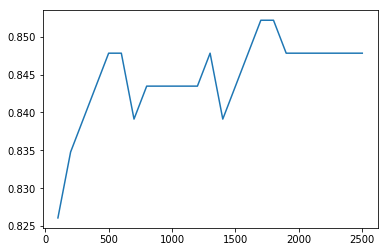

[0.8260869565217391, 0.8347826086956521, 0.8391304347826087, 0.8434782608695652, 0.8478260869565217, 0.8478260869565217, 0.8391304347826087, 0.8434782608695652, 0.8434782608695652, 0.8434782608695652, 0.8434782608695652, 0.8434782608695652, 0.8478260869565217, 0.8391304347826087, 0.8434782608695652, 0.8478260869565217, 0.8521739130434782, 0.8521739130434782, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217]


In [358]:
k = range(100,2600,100)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(3)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

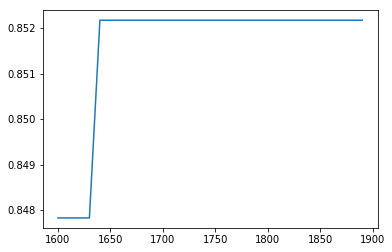

[0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782]


In [359]:
k = range(1600,1900,10)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(3)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

### cancel stop words

In [360]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,323808103780990976,RT @VitoCaro7: Good luck to @kyle_piersma toda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @vitocaro7 : good luck to @kyle_piersma tod...
1,323873597825355778,RT @DianneG: wow. RT @AntDeRosa Photo captures...,Outsiders,Other Useful Information,Related and informative,Related and informative,rt @dianneg : wow . rt @antderosa photo captur...
2,323874466063085568,Awful scenes at the #BostonMarathon. The photo...,Not applicable,Other Useful Information,Related - but not informative,Not related or not informative,awful scene at the #bostonmarathon . the photo...
3,323874558325161984,Holy shit RT @theoriginalwak: What the fuck ju...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative,holy shit rt @theoriginalwak : what the fuck j...
4,323875384603058176,RT @russian_market: BOMB EXPLOSION IN BOSTON (...,Media,Other Useful Information,Related and informative,Related and informative,rt @russian_market : bomb elosion in boston ( ...


In [361]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
count_pp_vec = CountVectorizer(analyzer='word')
X_count_pp_train = count_pp_vec.fit_transform(X_train2)  
X_count_pp_test = count_pp_vec.transform(X_test2)

In [362]:
mnb_count_pp = MultinomialNB(1)  
mnb_count_pp.fit(X_count_pp_train, y_train2)

evaluate_cross_validation(mnb_count_pp, X_count_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_count_pp.score(X_count_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_count_pp.score(X_count_pp_test, y_test2))

[0.7826087  0.82608696 0.73913043 0.82608696 0.79710145 0.82608696
 0.73913043 0.7826087  0.85507246 0.8115942 ]
Mean score: 0.799 (+/-0.012)
Accuracy for training: 0.947826086957
Accuracy for testing: 0.869565217391


In [363]:
y_count_pp_predict = mnb_count_pp.predict(X_count_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_count_pp_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_count_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8658    0.9281    0.8958       139
       Related and informative     0.8765    0.7802    0.8256        91

                   avg / total     0.8700    0.8696    0.8680       230

Confusion Matrix:
[[129  10]
 [ 20  71]]


In [364]:
X_count_pp_test.shape

(230, 2517)

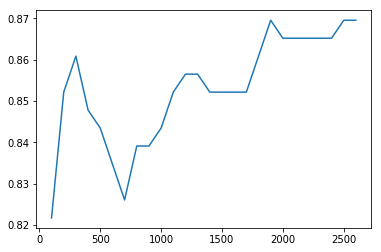

[0.8217391304347826, 0.8521739130434782, 0.8608695652173913, 0.8478260869565217, 0.8434782608695652, 0.8347826086956521, 0.8260869565217391, 0.8391304347826087, 0.8391304347826087, 0.8434782608695652, 0.8521739130434782, 0.8565217391304348, 0.8565217391304348, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8608695652173913, 0.8695652173913043, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478, 0.8695652173913043, 0.8695652173913043]


In [365]:
k = range(100,2700,100)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(1)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score